In [1]:
!ls /kaggle/input/global-wheat-detection
!cp /kaggle/input/rcnnutils/engine.py .
!cp /kaggle/input/rcnnutils/utils.py .
!cp /kaggle/input/rcnnutils/coco_eval.py .
!cp /kaggle/input/rcnnutils/coco_utils.py .
!cp /kaggle/input/rcnnutils/transforms.py .

sample_submission.csv  test  train  train.csv


In [2]:
!mkdir -p /root/.cache/torch/checkpoints
!cp /kaggle/input/resnet101/resnet101-5d3b4d8f.pth /root/.cache/torch/checkpoints/

In [3]:
import os
import numpy as np
import pandas as pd

import gc
import cv2
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


import albumentations
from albumentations.pytorch.transforms import ToTensorV2

import matplotlib.pyplot as plt
import utils

In [4]:
DATA_DIR = '/kaggle/input/global-wheat-detection'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
DETECTION_THRESHOLD = 0.40

In [5]:
sample_sub_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
sample_sub_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [6]:
def get_model(pre_trained=True):
    
    # Reference: https://stackoverflow.com/questions/58362892/resnet-18-as-backbone-in-faster-r-cnn
    resnet_net = torchvision.models.resnet101(pretrained=True) 
    modules = list(resnet_net.children())[:-2]

    backbone = nn.Sequential(*modules)
    backbone.out_channels = 2048

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    
    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator)
    return model

In [7]:
model = get_model(pre_trained=False)
model.to(DEVICE)
model.load_state_dict(torch.load(f'/kaggle/input/gwd-fasterrcnn-with-resnet101-backbone/fasterrcnn__resnet101_augmented_16.pth', map_location=DEVICE))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [8]:
!cp /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth .

In [9]:
class WheatDataset(Dataset):
    
    def __init__(self, image_ids, transforms):
        self.image_ids = image_ids
        self.transforms = albumentations.Compose([
                            ToTensorV2(p=1.0)
                        ])
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        image = cv2.imread(os.path.join(DATA_DIR, 'test', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        return image_id, image

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatDataset(os.listdir(os.path.join(DATA_DIR, 'test')), None)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

results = []

for image_ids, images in test_data_loader:

    images = list(image.to(DEVICE) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
        scores = scores[scores >= DETECTION_THRESHOLD]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [11]:
# !rm -rf *

In [12]:
sub_df = pd.DataFrame(results)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,image_id,PredictionString
0,cc3532ff6,0.9999 771 828 167 161 0.9998 551 822 136 182 ...
1,796707dd7,0.9983 370 624 111 136 0.9980 899 329 105 93 0...
2,53f253011,0.9998 21 587 128 158 0.9994 10 36 150 108 0.9...
3,51f1be19e,0.9996 614 87 153 156 0.9992 266 465 156 126 0...
4,f5a1f0358,0.9996 131 750 175 122 0.9994 936 422 88 196 0...


## Plotting some of the predictions

In [13]:
def get_bboxes(pred_str):
    span=5
    preds = pred_str.split()
    bboxes = [list(map(int, preds[i+1:i+span] )) for i in range(0, len(preds), span)]
    return bboxes

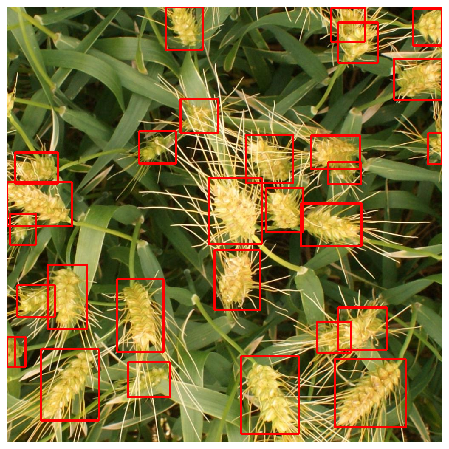

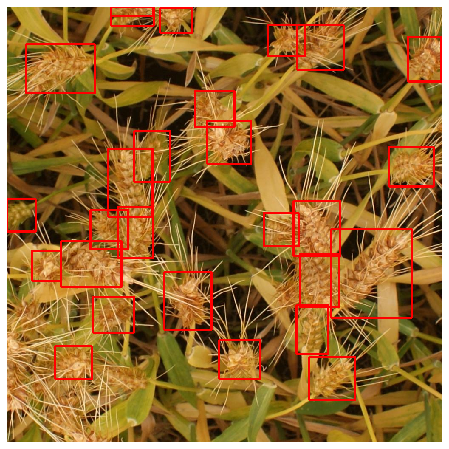

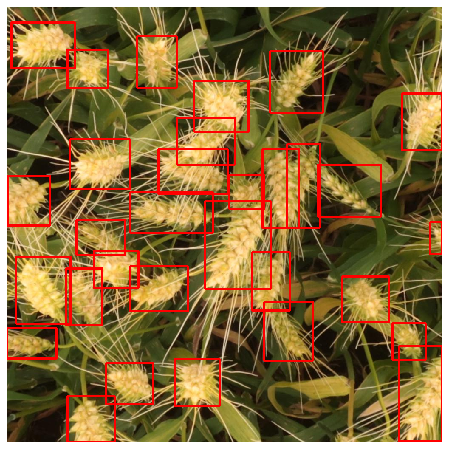

In [14]:
for image_id, pred_str in zip(sub_df.iloc[:3]['image_id'], sub_df.iloc[:3]['PredictionString']):
    image_path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    boxes = get_bboxes(pred_str)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2]+box[0], box[3]+box[1]),
                      (255, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)
    plt.show()